# Convert the Radar Data Format to Row-Wise Format

In [1]:
import os
import sys
from pathlib import Path

def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))

In [2]:
import pandas as pd
import numpy as np

## Read in the data

In [3]:
DATA_DIR = ROOT / "data" / "2023-01-13"

pwlf_data = pd.read_parquet(DATA_DIR / "pwlf_method.parquet")
lowess_data = pd.read_parquet(DATA_DIR / "lowess_method.parquet")
headway_data = pd.read_parquet(DATA_DIR / "headway.parquet")
headway_data.set_index("veh", inplace=True)
headway_data = headway_data[headway_data["mean"] > 0.20]


vehicle_length_table = pd.read_parquet(
    DATA_DIR / "car_lengths.parquet"
)
# only keep lengths that are greater than 2m
vehicle_length_table = vehicle_length_table[vehicle_length_table["f32_length_m"] >= 2.0]

In [4]:
vehicle_length_table.head()

,ui32_objectID,f32_length_m
0,35256,3.327021
1,35257,8.543118
2,35258,4.468826
3,35259,4.739034
4,35260,3.769435


### Label the Operation Modes

In [5]:
# pwlf_data['method'] = 'pwlf'
# lowess_data['method'] = 'lowess'
# data = pd.concat([pwlf_data, lowess_data], axis=0)

In [6]:
cruise_thresh = 0.1
minium_time_in_state = 1


pwlf_data['type'] = np.where(pwlf_data['accel'] > cruise_thresh, 'accel', '')
pwlf_data['type'] = np.where(pwlf_data['accel'] < -cruise_thresh, 'decel', pwlf_data['type'])
pwlf_data['type'] = np.where(pwlf_data['accel'].abs() <= cruise_thresh, 'cruise', pwlf_data['type'])


base_filter = (pwlf_data['time_diff'] > minium_time_in_state) & (pwlf_data['r2'] > .9)
pwlf_data_accel = pwlf_data[(pwlf_data['type'] == 'accel') & base_filter].groupby('vehicle_id').apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)
pwlf_data_decel = pwlf_data[(pwlf_data['type'] == 'decel') & base_filter].groupby('vehicle_id').apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)

minium_time_in_state = 0
pwlf_data_cruise = pwlf_data[(pwlf_data['type'] == 'cruise') & (pwlf_data['time_diff'] > minium_time_in_state)].groupby('vehicle_id').apply(
    lambda x: np.average(x['speed'], weights=x['time_diff'])
)

In [7]:
cruise_thresh = 0.1
minium_time_in_state = 1

lowess_data['type'] = np.where(lowess_data['accel'] > cruise_thresh, 'accel', '')
lowess_data['type'] = np.where(lowess_data['accel'] < -cruise_thresh, 'decel', lowess_data['type'])
lowess_data['type'] = np.where(lowess_data['accel'].abs() <= cruise_thresh, 'cruise', lowess_data['type'])


base_filter = (lowess_data['time_diff'] > minium_time_in_state)
lowess_accel = lowess_data[(lowess_data['type'] == 'accel') & base_filter].groupby('vehicle_id').apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)
lowess_decel = lowess_data[(lowess_data['type'] == 'decel') & base_filter].groupby('vehicle_id').apply(
    lambda x: np.average(x['accel'], weights=x['time_diff'])
)


minium_time_in_state = 0.01
base_filter = (lowess_data['time_diff'] > minium_time_in_state)
lowess_cruise = lowess_data[(lowess_data['type'] == 'cruise') & base_filter].groupby('vehicle_id').apply(
    lambda x: np.average(x['speed'], weights=x['time_diff'])
)

### Plotting

In [8]:

def hist_ecdf(*plots, ax, colors, limits):

    for i, plot_series in enumerate(plots):
        ax.hist(
            plot_series[1],
            bins=100,
            label=plot_series[0],
            alpha=0.5,
            density=True,
            color=colors[i],
        )

        # create a ecdf of the acceleration values on the right y-axis
        ax2 = ax.twinx()
        ax2.scatter(
            np.sort(plot_series[1].values),
            np.linspace(0, 1, len(plot_series[1].values)),
            label=plot_series[0],
            alpha=1,
            s=1,
            color=colors[i],
        )

    # set x-axis limits
    ax.set_xlim(*limits)



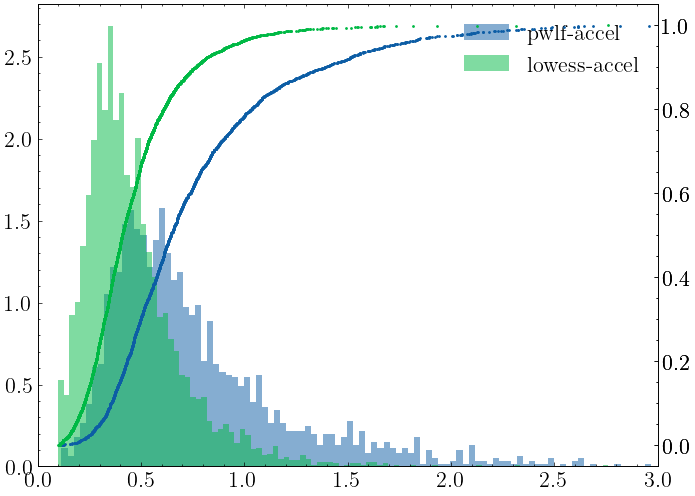

In [9]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("science")
plt.rcParams.update({"font.size": 16})

# create a color palette
palette = colors = sns.color_palette("Paired", 8, desat=0.8)
# get every other color
colors = [palette[i] for i in range(0, len(palette), 2)]

# plot pwlf accel vs decel
fig, ax = plt.subplots(figsize=(8, 6))
hist_ecdf(
    ("pwlf-accel", pwlf_data_accel),
    ("lowess-accel", lowess_accel),
    ax=ax,
    colors=["C0", "C1"],
    limits=(0, 3),
)

ax.legend()


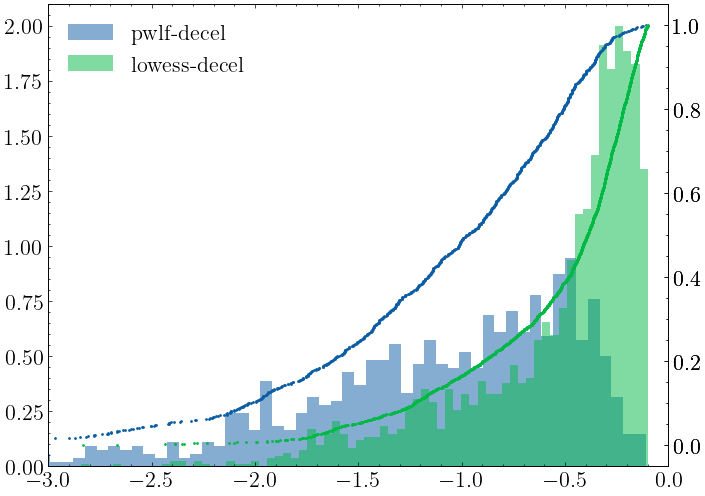

In [10]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("science")
plt.rcParams.update({"font.size": 16})

# create a color palette
palette = colors = sns.color_palette("Paired", 8, desat=0.8)
# get every other color
colors = [palette[i] for i in range(0, len(palette), 2)]

# plot pwlf accel vs decel
fig, ax = plt.subplots(figsize=(8, 6))
hist_ecdf(
    ("pwlf-decel", pwlf_data_decel),
    ("lowess-decel", lowess_decel),
    ax=ax,
    colors=["C0", "C1"],
    limits=(-3, 0),
)

ax.legend()


### Additional Cruise Filtering

In [11]:
filter_ = lowess_cruise.index.isin(headway_data[headway_data['mean'] > 5].index) &  (lowess_data.loc[lowess_data.vehicle_id.isin(lowess_cruise.index)].groupby('vehicle_id')['accel'].max().loc[lowess_cruise.index].abs() < 1)
lowess_cruise_new = lowess_cruise[filter_]

# do the same for pwlf
filter_ = pwlf_data_cruise.index.isin(headway_data[headway_data['mean'] > 5].index) &  (pwlf_data.loc[pwlf_data.vehicle_id.isin(pwlf_data_cruise.index)].groupby('vehicle_id')['accel'].max().loc[pwlf_data_cruise.index].abs() < 1)
pwlf_data_cruise_new = pwlf_data_cruise[filter_]

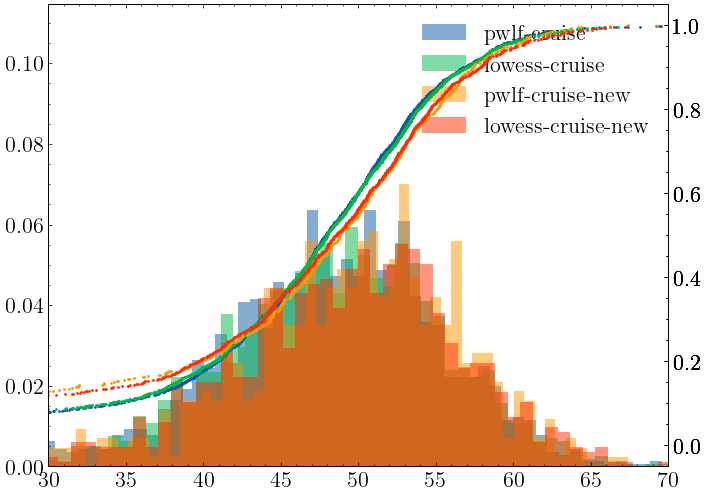

In [12]:
# plot pwlf accel vs decel
fig, ax = plt.subplots(figsize=(8, 6))
hist_ecdf(
    ("pwlf-cruise", pwlf_data_cruise * 2.23694),
    ("lowess-cruise", lowess_cruise * 2.23694),
    ("pwlf-cruise-new", pwlf_data_cruise_new * 2.23694),
    ("lowess-cruise-new", lowess_cruise_new * 2.23694),
    ax=ax,
    colors=["C0", "C1", "C2", "C3"],
    limits=(30, 70),
)

ax.legend()

In [13]:
# create the speed factors
speed_limit = 22.35

# create the speed factors
pwlf_data_cruise_new = pwlf_data_cruise_new / speed_limit
lowess_cruise_new = lowess_cruise_new / speed_limit

# filter out low end. Nothing slower than 35 mph
filter_ = pwlf_data_cruise_new > (35 / (speed_limit * 2.23694))
pwlf_data_cruise_new = pwlf_data_cruise_new[filter_]

filter_ = lowess_cruise_new > (35 / (speed_limit * 2.23694))
lowess_cruise_new = lowess_cruise_new[filter_]

### Create a DataFrame for SUMO

In [14]:
# only keep headway data where the vehicle has headway < 5
merge_headway = headway_data[headway_data['mean'] < 5]

In [15]:
lowess_df = lowess_accel.to_frame("accel").merge(lowess_decel.to_frame("decel"), left_index=True, right_index=True, how="inner")
corr_lowess_df = lowess_df.merge(merge_headway.rename({'mean': "tau"}, axis=1), left_index=True, right_index=True, how="inner")
corr_lowess_df['decel'] = corr_lowess_df['decel'] * -1
corr_lowess_df = corr_lowess_df.merge(
    vehicle_length_table, left_index=True, right_on='ui32_objectID', how="inner"
).rename(
    {'f32_length_m': 'length'}, axis=1
).drop(
    ['ui32_objectID'], axis=1
)

# # try to merge with cruise data
# print(corr_lowess_df.shape)
# corr_lowess_df = corr_lowess_df.merge(lowess_cruise_new.to_frame("speedFactor"), left_index=True, right_index=True, how="inner")
# print(corr_lowess_df.shape)

In [16]:
corr_lowess_df['speedFactor'] = np.random.choice(lowess_cruise_new, size=corr_lowess_df.shape[0])

In [17]:
samples = 10000

np.random.seed(42)

# create a random sample of the data
uncor_lowess_df = pd.DataFrame(
    {
        "accel": np.random.choice(lowess_accel, samples),
        "decel": np.random.choice(lowess_decel, samples),
        "tau": np.random.choice(merge_headway['mean'], samples),
        'length': np.random.choice(vehicle_length_table['f32_length_m'], samples),
        'speedFactor': np.random.choice(lowess_cruise_new, samples) 
    }
)

In [18]:
pwlf_df = pwlf_data_accel.to_frame("accel").merge(pwlf_data_decel.to_frame("decel"), left_index=True, right_index=True, how="inner")
corr_pwlf_df = pwlf_df.merge(merge_headway.rename({'mean': "tau"}, axis=1), left_index=True, right_index=True, how="inner")
corr_pwlf_df['decel'] = corr_pwlf_df['decel'] * -1
corr_pwlf_df = corr_pwlf_df.merge(
    vehicle_length_table, left_index=True, right_on='ui32_objectID', how="inner"
).rename(
    {'f32_length_m': 'length'}, axis=1
).drop(
    ['ui32_objectID'], axis=1
)
corr_pwlf_df['speedFactor'] = np.random.choice(pwlf_data_cruise_new, size=corr_pwlf_df.shape[0])

In [19]:
corr_pwlf_df.corr()

,accel,decel,tau,length,speedFactor
accel,1.000000,0.616115,0.050112,0.406077,-0.083464
decel,0.616115,1.000000,0.153900,0.262936,-0.122518
tau,0.050112,0.153900,1.000000,-0.000978,0.021152
length,0.406077,0.262936,-0.000978,1.000000,-0.137855
speedFactor,-0.083464,-0.122518,0.021152,-0.137855,1.000000


In [23]:
corr_pwlf_df.head()

,accel,decel,tau,length,speedFactor
158,1.060730,0.808256,3.728117,7.667360,1.059991
561,1.425515,2.039264,3.480033,5.042850,1.035955
897,1.599247,1.007088,3.760604,3.998712,1.109576
1048,1.169814,0.861960,2.299340,4.233599,1.113266
1189,0.425368,0.659508,3.975626,3.561811,0.846303


In [20]:
samples = 10000

np.random.seed(42)

# create a random sample of the data
uncor_pwlf_df = pd.DataFrame(
    {
        "accel": np.random.choice(pwlf_data_accel, samples),
        "decel": np.random.choice(pwlf_data_decel, samples),
        "tau": np.random.choice(merge_headway['mean'], samples),
        'length': np.random.choice(vehicle_length_table['f32_length_m'], samples),
        'speedFactor': np.random.choice(pwlf_data_cruise_new, samples)
    }
)

In [21]:
uncor_pwlf_df.corr()

,accel,decel,tau,length,speedFactor
accel,1.000000,-0.007670,-0.001515,0.015159,0.001721
decel,-0.007670,1.000000,-0.003968,-0.013732,0.011099
tau,-0.001515,-0.003968,1.000000,-0.001527,-0.014428
length,0.015159,-0.013732,-0.001527,1.000000,0.005494
speedFactor,0.001721,0.011099,-0.014428,0.005494,1.000000


### Save the data

In [22]:
def save_df_to_csv(df, filename):
    df['vClass'] = 'passenger'
    # this is dumb for now, but it works
    df['emissionClass'] = df['vClass'].map({
        'passenger': 'PHEMlight/PC_G_EU4',
        'trailer': 'PHEMlight/HDV_TT_D_EU6'
    })

    df['decel'] = df['decel'].abs()

    df.to_csv(filename, index=False)

In [20]:
save_df_to_csv(uncor_pwlf_df, "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/uncor_pwlf.csv")
save_df_to_csv(uncor_lowess_df, "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/uncor_lowess.csv")
save_df_to_csv(corr_pwlf_df, "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/corr_pwlf.csv")
save_df_to_csv(corr_lowess_df, "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/corr_lowess.csv")

## Plotting

In [55]:
import corner
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

# make the text bigger
plt.rcParams.update({'font.size': 16})

In [58]:
corr_pwlf_df

,accel,decel,tau,length,vClass,emissionClass
158,1.060730,0.808256,3.728117,7.667360,passenger,PHEMlight/PC_G_EU4
561,1.425515,2.039264,3.480033,5.042850,passenger,PHEMlight/PC_G_EU4
812,1.231003,0.863788,0.372336,8.423108,passenger,PHEMlight/PC_G_EU4
855,1.142745,0.739735,0.807852,7.175735,passenger,PHEMlight/PC_G_EU4
897,1.599247,1.007088,3.760604,3.998712,passenger,PHEMlight/PC_G_EU4
...,...,...,...,...,...,...
28866,0.875711,0.364064,2.328853,4.363883,passenger,PHEMlight/PC_G_EU4
28900,0.343210,0.477661,1.097254,8.098736,passenger,PHEMlight/PC_G_EU4
28931,0.152972,0.547375,4.728937,4.075989,passenger,PHEMlight/PC_G_EU4
28982,0.603062,0.348074,3.461915,4.374584,passenger,PHEMlight/PC_G_EU4


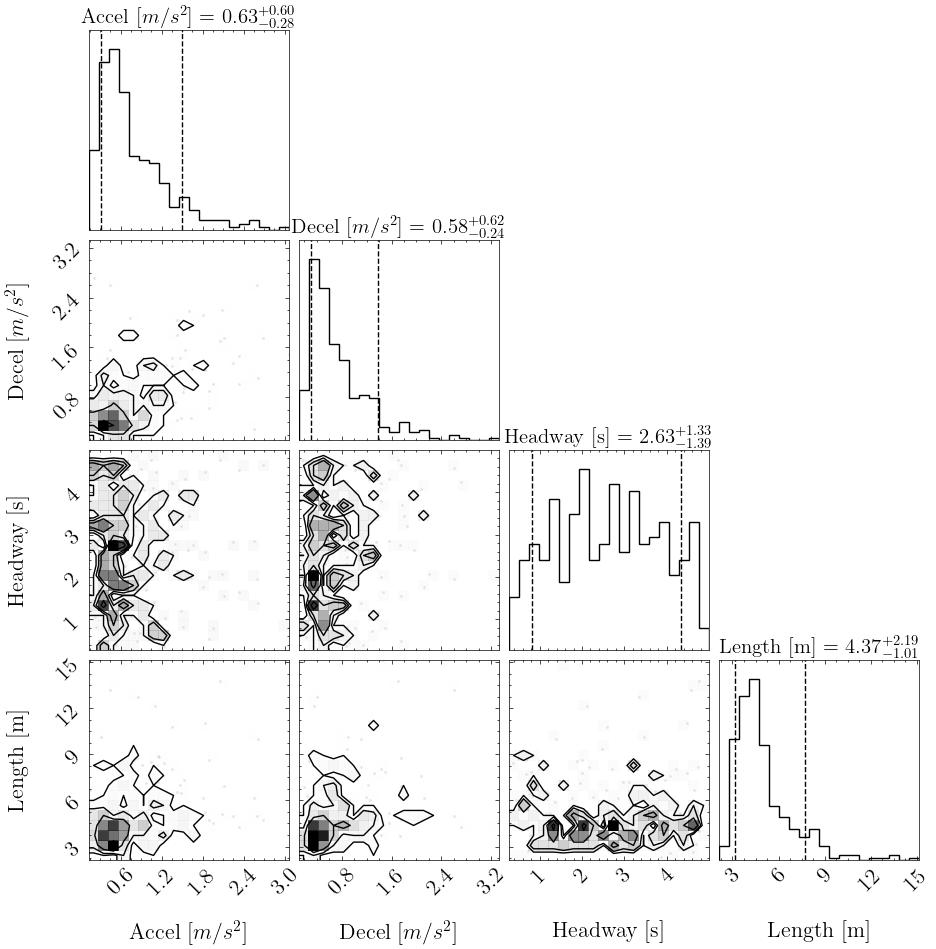

In [59]:
fig = corner.corner(
    corr_pwlf_df[['accel',	'decel',	'tau',	'length']], #[['accel', 'decel']],
    labels=['Accel [$m/s^2$]', 'Decel [$m/s^2$]', "Headway [s]", "Length [m]"],
    quantiles=(0.1, 0.9),
    show_titles=True,
    title_kwargs={"fontsize": 15},
)

# mean = accel_decel_df[['accel', 'decel']].mean()

# corner.overplot_lines(fig, mean, )

# # set the axis limits
# for ax in fig.axes:
#     ax.set_xlim(0, 4)

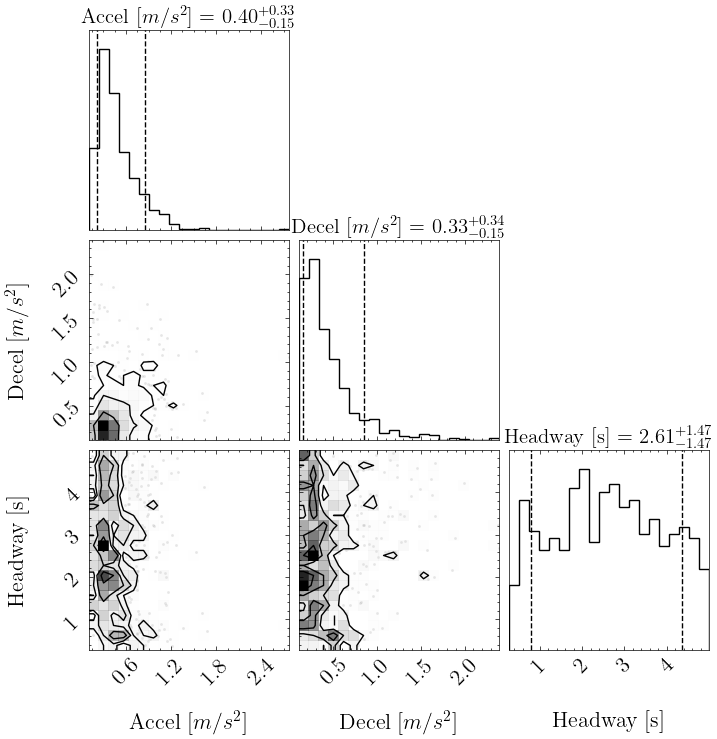

In [173]:
fig = corner.corner(
    corr_lowess_df, #[['accel', 'decel']],
    labels=['Accel [$m/s^2$]', 'Decel [$m/s^2$]', "Headway [s]"],
    quantiles=(0.1, 0.9),
    show_titles=True,
    title_kwargs={"fontsize": 15},
)


### Create a where a row represents a vehicle and the columns are accel and decel

In [5]:
keep_vehicles = types_df.loc[(types_df['type_accel'] > 0) & (types_df['type_decel'] > 0)].index

In [6]:
both_vehicles = accel_deccel_df.loc[accel_deccel_df.vehicle_id.isin(keep_vehicles)]

In [7]:
groups = []
for name, group in both_vehicles[['vehicle_id', 'type', 'slope']].groupby(['vehicle_id']):
    # group[['type', 'slope']]
    accels = group.loc[group.type == 'accel', 'slope'].values
    decels = group.loc[group.type == 'decel', 'slope'].values
    # create combinations of accel and decel
    groups.extend(({'id': name, 'accel': accel, 'decel': decel}) for decel in decels for accel in accels)
    

/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_22692/388982627.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in both_vehicles[['vehicle_id', 'type', 'slope']].groupby(['vehicle_id']):


In [8]:
accel_decel_df = pd.DataFrame(groups)

In [9]:
accel_decel_df.head()

,id,accel,decel
0,55583,0.786503,-1.706129
1,55587,1.674436,-0.988193
2,55587,1.674436,-1.784263
3,55596,1.383191,-1.004798
4,55596,1.383191,-1.669873


### Clean it up and get it ready for SUMO

In [10]:
accel_decel_df['decel'] = accel_decel_df['decel'].abs()
accel_decel_df.drop('id', axis=1, inplace=True)

### Add the Vehicle Type

In [11]:
accel_decel_df['vClass'] = 'passenger' #np.random.choice(['passenger', 'trailer'], N, p=[0.8, 0.2])
accel_decel_df['emissionClass'] = accel_decel_df['vClass'].map({
    'passenger': 'PHEMlight/PC_G_EU4',
    'trailer': 'PHEMlight/HDV_TT_D_EU6'
})

## Add the Speed

In [12]:
import sumolib

In [13]:
net = sumolib.net.readNet(ROOT / "sumo-xml" / "net" / "simplified_reworked.net.xml")

In [14]:
e = net.getEdge("gneE11")
edgeSpeed = e.getSpeed()

In [15]:
cruise_df = df.loc[(df["type"] == "cruise") & (df["speed"] > 17) & (df["rmse"] < 0.05)].copy()

In [16]:
sf_table = cruise_df['speed'] / edgeSpeed

In [17]:
accel_decel_df['speedFactor'] = sf_table.sample(accel_decel_df.shape[0], replace=True).values

In [18]:
accel_decel_df.to_csv(ROOT / 'data'/ 'rw_east_thru_summary_accel_decel.csv', index=False)

<AxesSubplot: >

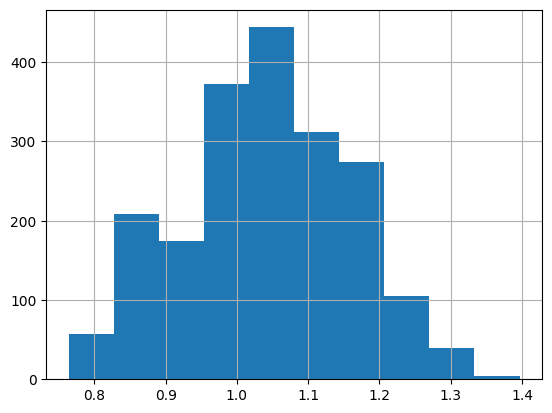

In [19]:
accel_decel_df['speedFactor'].hist()

In [49]:
# reduce the number of decimal places
print(accel_decel_df[['accel', 'decel']].corr().style.format("{:.2f}").to_latex())

NameError: name 'accel_decel_df' is not defined